In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import abline_plot
import statsmodels.stats.outliers_influence as st_inf
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
%matplotlib inline

# 3.6.2 Simple Linear Regression

Load the Boston housing dataset and perform a basic regression. The book uses R. I'm going to use statsmodels and scikit-learn

In [2]:
df = sm.datasets.get_rdataset("Boston", "MASS", cache=True).data
df = sm.add_constant(df)

/home/cornucrapia/miniconda3/envs/isl/lib/python3.7/site-packages/statsmodels/datasets/utils.py:192: FutureWarning: `item` has been deprecated and will be removed in a future version
  return dataset_meta["Title"].item()
/home/cornucrapia/miniconda3/envs/isl/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [3]:
df.head()

,const,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,1.0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,1.0,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,1.0,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,1.0,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,1.0,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## scikit-learn implementation

Not happy that I had to do this weird reshape just because I only had one independent variable. Maybe there's a better way?

In [4]:
%%timeit
boston_skl_ols = LinearRegression()
boston_skl_ols.fit(df["lstat"].to_numpy().reshape(-1, 1), df["medv"])

399 µs ± 23.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
boston_skl_ols = LinearRegression()
boston_skl_ols.fit(df["lstat"].to_numpy().reshape(-1, 1), df["medv"])
print("Coefficients: \n", boston_skl_ols.coef_)
print("Intercept: \n", boston_skl_ols.intercept_)

Coefficients: 
 [-0.95004935]
Intercept: 
 34.55384087938311


While it's not as verbose in estimation output, or at least I don't see an easy way to make it be, it's sure a lot faster, which makes sense given what it's designed for.

I think I'll stick with StatsModels for the rest of this

## StatsModels Implementation

Where possible I prefer to use StatsModels. Scikit is great, and if I wanted to do a pure prediction I might prefer it, but StatsModels gives me all that analytic goodness I'm looking for.

In [6]:
%%timeit
boston_sm_ols = sm.OLS(df["medv"], df[["const", "lstat"]]).fit()

1.03 ms ± 50.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Run regression and display basic summary stats

In [7]:
boston_sm_ols = sm.OLS(df["medv"], df[["const", "lstat"]]).fit()
print(boston_sm_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Mon, 30 Sep 2019   Prob (F-statistic):           5.08e-88
Time:                        20:27:25   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.5538      0.563     61.415      0.0

A lot of the details are available in summary, but they can also be accessed using methods if you want to use them in further programming

In [8]:
boston_sm_ols.conf_int(alpha=0.05)

,0,1
const,33.448457,35.659225
lstat,-1.026148,-0.873951


Calculate confidence and prediction intervals for a set of independent variables (note the call to add_constant to include the intercept)

In [9]:
boston_sm_ols.get_prediction(sm.add_constant([5, 10, 15])).summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,29.803594,0.405247,29.007412,30.599776,17.565675,42.041513
1,25.053347,0.294814,24.474132,25.632563,12.827626,37.279068
2,20.303101,0.290893,19.731588,20.874613,8.077742,32.528459


To plot the regression there is a way to do it in StatsModels, but the nicer way is probably Seaborn, let's try both

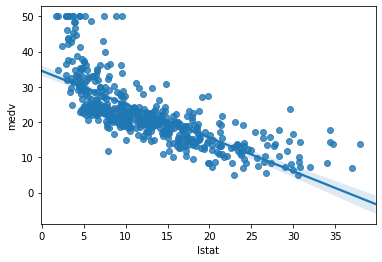

In [10]:
sns.regplot(x='lstat', y='medv', data=df);

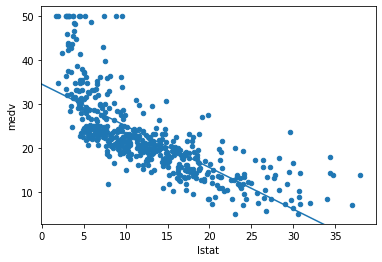

In [11]:
ax = df.plot(x='lstat', y='medv', kind='scatter')
abline_plot(model_results=boston_sm_ols, ax=ax);

Analyse residuals

In [12]:
# make a new dataframe for easier plotting
result_df = df[["lstat", "medv"]].copy()
result_df["fitted"] = boston_sm_ols.fittedvalues
result_df["resid"] = boston_sm_ols.resid

Basic residuals

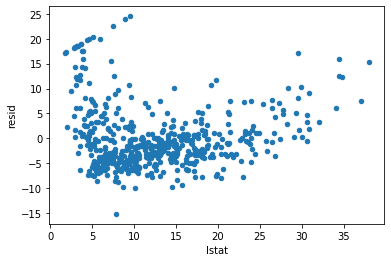

In [13]:
result_df.plot(x="lstat", y="resid", kind="scatter");

Plot leverage against studentized residuals

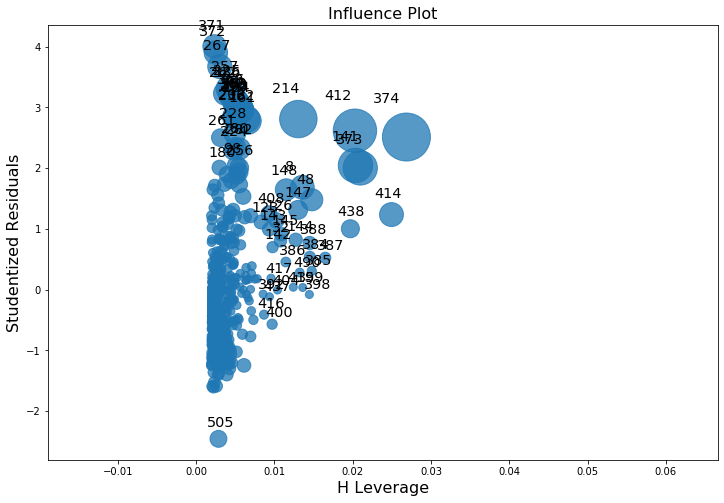

In [14]:
fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(boston_sm_ols, ax=ax, criterion="cooks")

Can also get leverage and a bunch of other summary stats in numeric form, in ISL the lab shows which observation has the highest leverage

In [15]:
boston_influence = st_inf.OLSInfluence(boston_sm_ols).summary_frame()

In [16]:
boston_influence["hat_diag"].idxmax()

374

ISL returns 375 for this, but I'm guessing that's just because R counts from 1 and python indices are from 0

# 3.6.3 Multiple Linear Regression

Still using StatsModels, going to start using the same variable names as ISL going forward

In [17]:
lm = sm.OLS(df["medv"], df[["const", "lstat", "age"]]).fit()

In [18]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     309.0
Date:                Mon, 30 Sep 2019   Prob (F-statistic):           2.98e-88
Time:                        20:27:26   Log-Likelihood:                -1637.5
No. Observations:                 506   AIC:                             3281.
Df Residuals:                     503   BIC:                             3294.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.2228      0.731     45.458      0.0

In [19]:
X = df.drop(columns="medv")
y = df["medv"]
lm = sm.OLS(y, X).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                   medv   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     108.1
Date:                Mon, 30 Sep 2019   Prob (F-statistic):          6.72e-135
Time:                        20:27:26   Log-Likelihood:                -1498.8
No. Observations:                 506   AIC:                             3026.
Df Residuals:                     492   BIC:                             3085.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         36.4595      5.103      7.144      0.0

More examples of accessing individual attributes. ISL pulls $R^2$ and RSE so I'll do the same

In [20]:
print(f"R squared: {lm.rsquared:0.3}, RSE: {lm.mse_resid:0.3}")

R squared: 0.741, RSE: 22.5


In [29]:
for col in X.columns:
    idx = list(X.columns).index(col)
    vif = st_inf.variance_inflation_factor(X.to_numpy(), idx)
    print(f"Variance Inflation Factor (VIF) for {col}: {vif:0.1}")

Variance Inflation Factor (VIF) for const: 6e+02
Variance Inflation Factor (VIF) for crim: 2e+00
Variance Inflation Factor (VIF) for zn: 2e+00
Variance Inflation Factor (VIF) for indus: 4e+00
Variance Inflation Factor (VIF) for chas: 1e+00
Variance Inflation Factor (VIF) for nox: 4e+00
Variance Inflation Factor (VIF) for rm: 2e+00
Variance Inflation Factor (VIF) for age: 3e+00
Variance Inflation Factor (VIF) for dis: 4e+00
Variance Inflation Factor (VIF) for rad: 7e+00
Variance Inflation Factor (VIF) for tax: 9e+00
Variance Inflation Factor (VIF) for ptratio: 2e+00
Variance Inflation Factor (VIF) for black: 1e+00
Variance Inflation Factor (VIF) for lstat: 3e+00


### 3.6.4 Interaction Terms

more to look into here: https://www.statsmodels.org/dev/examples/notebooks/generated/regression_plots.html